In [8]:
import numpy as np
import matplotlib.pyplot as plt
from gasp.simulation import simulate_ssfp, simulate_gasp, view_gasp_input, view_gasp_comparison
from gasp import responses

In [9]:
# We want to know how the choice of the basis sets impacts GASP performance
# We ideally wish to find a set of phase-cycled images that can most accurately reconstruct the desired spectral response
# Optimization Parameters
#     TRs
#     PCs
#     alpha
#     gradient (may not be very helpful because you do have adjust in-situ)
# Cost function (for a set of possible desired spectral profiles over a single-species T2/T1 sample)
#     sum_i || f_i - Ac ||^2_2
#
#     def cost(x):
#         alpha = x[0, :]
#         TRs = x[1, :]
#         PCs = x[2, :]
#         grad = x[3, :]
#         Ic, M, An = simulate_gasp(desired_fun, alpha, TRs, PCs, grad)
#         return np.linalg.norm(desired_fun - Ic)**2
#
# Constraints
#     (total number of phase cycles) <= K

In [10]:
# choose parameters
width, height = 256, 256
alpha = np.deg2rad(100)
gradient = 2 * np.pi
phantom_type = "circle"
#TRs = (5e-3, 10e-3, 12e-3)
TRs = (5e-3, 10e-3, 12e-3)
T1, T2 = 250e-3, 7e-3
nPCs = 16
PCs = np.linspace(-2*np.pi, 2*np.pi, nPCs, endpoint=False)

In [11]:
M = simulate_ssfp(width=width, height=height, npcs=nPCs, TRs=TRs, alpha=alpha, gradient=gradient, phantom_type=phantom_type)
print(M.shape)

(256, 256, 1, 16, 3)


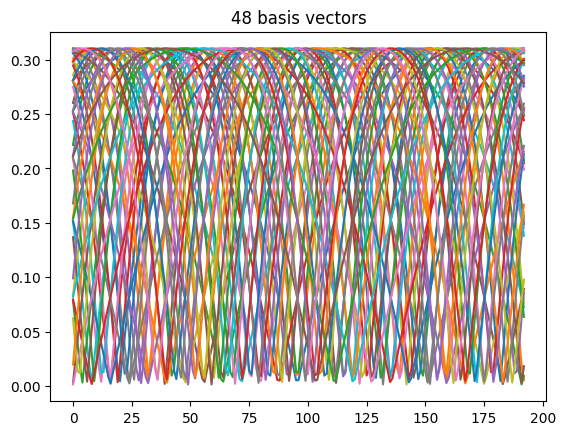

(48,)
48
3.339709001415666e-09


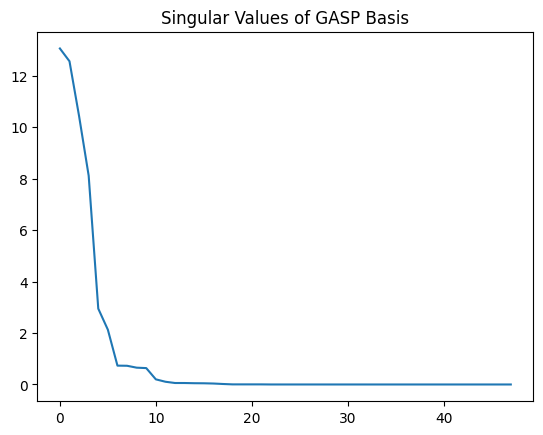

In [12]:
# do SVD to see how many small singular values we have
left_pad = (M[height // 2, :, 0, 0, 0] != 0).argmax()
right_pad = (M[height // 2, ::-1, 0, 0, 0] != 0).argmax()
basis = np.reshape(M[height // 2, left_pad:width-right_pad, ...], (width-right_pad-left_pad, -1))

plt.plot(np.abs(basis))
plt.title(f"{basis.shape[1]} basis vectors")
plt.show()

U, D, V = np.linalg.svd(basis, full_matrices=True)
print(D.shape)
tol = D.max() * np.finfo(basis.dtype).eps / 2.0 * np.sqrt(basis.shape[0] + basis.shape[1] + 1.0)
print(np.linalg.matrix_rank(basis, tol=tol))
print(D[-1])

plt.plot(D)
plt.title("Singular Values of GASP Basis")
plt.show()

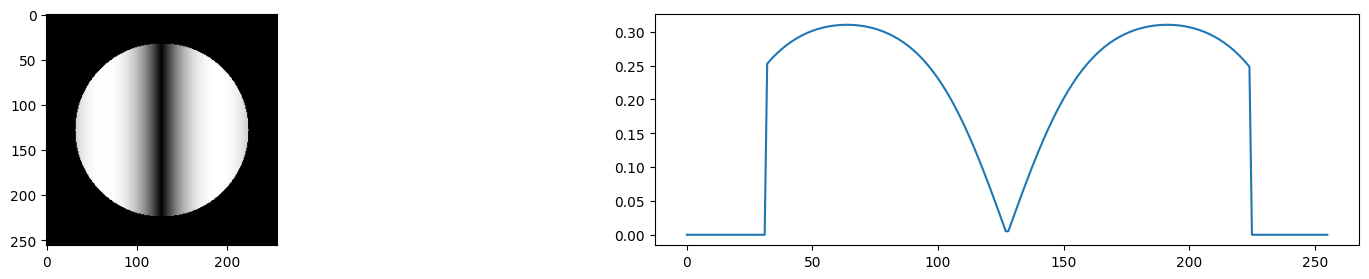

In [13]:
view_gasp_input(M)

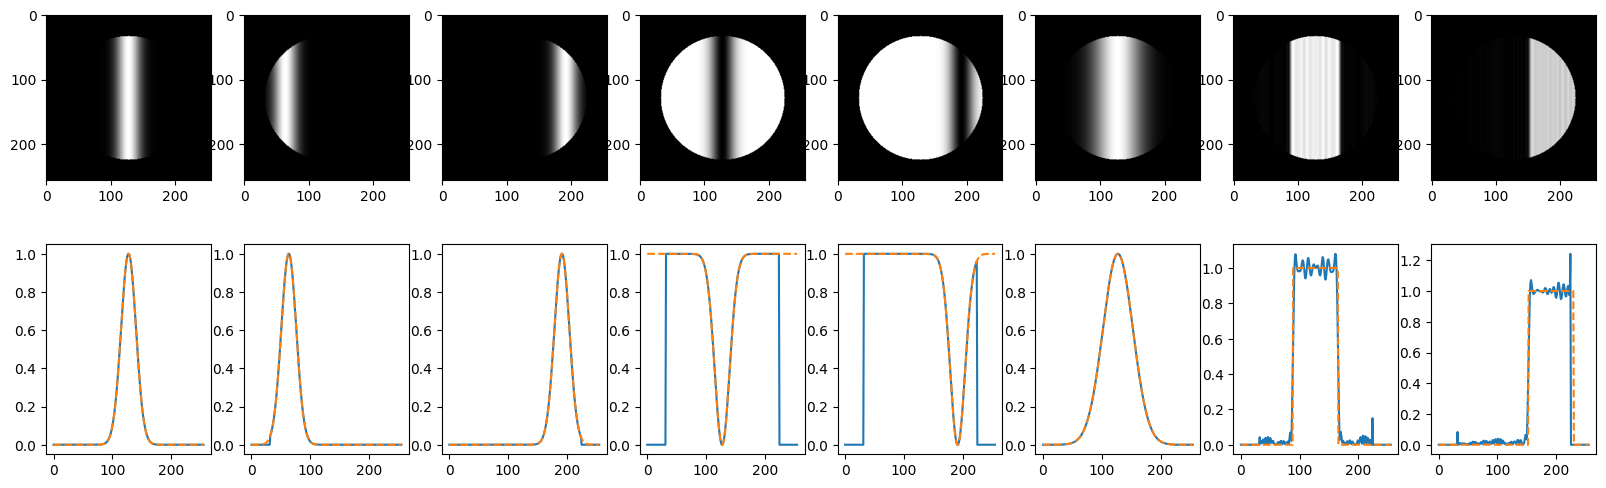

In [14]:
D = []
D.append(responses.gaussian(width, bw=0.2, shift=0))
D.append(responses.gaussian(width, bw=0.2, shift=-0.25))
D.append(responses.gaussian(width, bw=0.2, shift=0.25))
D.append(responses.notch(width, bw=0.2, shift=0))
D.append(responses.notch(width, bw=0.2, shift=0.25))
D.append(responses.gaussian(width, bw=0.4, shift=0))
D.append(responses.square(width, bw=0.3, shift=0))
D.append(responses.square(width, bw=0.3, shift=0.25))

G = []
A = []
for d in D:
    Ic, M, An = simulate_gasp(d, width=width, height=height, npcs=nPCs, TRs=TRs, alpha=alpha, gradient=gradient, phantom_type=phantom_type)
    G.append(Ic)
    A.append(An)

view_gasp_comparison(G, D)